# WASSA 2017 Shared Task On Emotion Intensity

In [1]:
import os
import sys
import pandas as pd
import numpy as np
from nltk.tokenize import TweetTokenizer
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor
from scipy.stats import spearmanr
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
%matplotlib  inline

# access local modules
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from emoint.featurizers.emoint_featurizer import EmoIntFeaturizer

In [2]:
def get_xy(path, tokenizer, featurizer):
    df = pd.read_csv(path, header=None, sep='\t')
    tweets = df[1]
    intensities = df[3]
    X = []
    for t in tweets:
        tokens = tokenizer.tokenize(t)
        features = featurizer.featurize(tokens)
        X.append(features)

    X, y = np.array(X), np.array(intensities)
    print("Shapes X: {}, y: {}".format(X.shape, y.shape))
    return X, y

# Evaluation Metrics
def metrics(y_pred, y, print_metrics=False):
    p1 = pearsonr(y_pred, y)[0]
    s1 = spearmanr(y_pred, y)[0]

    ind = np.where(y >= 0.5)
    ydt = np.take(y_pred, ind).reshape(-1)
    ydpt = np.take(y, ind).reshape(-1)

    p2 = pearsonr(ydt, ydpt)[0]
    s2 = spearmanr(ydt, ydpt)[0]

    if print_metrics:
        print("Validation Pearsonr: {}".format(p1))
        print("Validation Spearmanr: {}".format(s1))
        print("Validation Pearsonr >= 0.5: {}".format(p2))
        print("Validation Spearmanr >= 0.5: {}".format(s2))

    return np.array((p1, s1, p2, s2))

from sklearn.preprocessing import StandardScaler, RobustScaler

# Model Training
def train(train_path, dev_path):

    featurizer = EmoIntFeaturizer()
    tokenizer = TweetTokenizer()

    X_train, y_train = get_xy(train_path, tokenizer, featurizer)
    X_dev, y_dev = get_xy(dev_path, tokenizer, featurizer)

    regr = AdaBoostRegressor(GradientBoostingRegressor())
    regr.fit(X_train, y_train)
    
    y_dev_pred = regr.predict(X_dev)
    metrics(y_dev_pred, y_dev, True)
    
    return regr, featurizer.features

## Training Models

In [3]:
print("---------------- ANGER --------------------")
anger_regr, anger_features = train(
    '../resources/emoint/anger-ratings-0to1.train.txt',
    '../resources/emoint/anger-ratings-0to1.dev.gold.txt'
)

print("---------------- FEAR --------------------")
fear_regr, fear_features = train(
    '../resources/emoint/fear-ratings-0to1.train.txt',
    '../resources/emoint/fear-ratings-0to1.dev.gold.txt'
)

print("---------------- JOY --------------------")
joy_regr, joy_features = train(
    '../resources/emoint/joy-ratings-0to1.train.txt',
    '../resources/emoint/joy-ratings-0to1.dev.gold.txt'
)

print("---------------- SADNESS --------------------")
sadness_regr, sadness_features = train(
    '../resources/emoint/sadness-ratings-0to1.train.txt',
    '../resources/emoint/sadness-ratings-0to1.dev.gold.txt'
)

---------------- ANGER --------------------
Shapes X: (857, 155), y: (857,)
Shapes X: (84, 155), y: (84,)
Validation Pearsonr: 0.678433161445
Validation Spearmanr: 0.665187172317
Validation Pearsonr >= 0.5: 0.460469354407
Validation Spearmanr >= 0.5: 0.384856869389
---------------- FEAR --------------------
Shapes X: (1147, 155), y: (1147,)
Shapes X: (110, 155), y: (110,)
Validation Pearsonr: 0.545139586563
Validation Spearmanr: 0.507310008964
Validation Pearsonr >= 0.5: 0.456155250083
Validation Spearmanr >= 0.5: 0.437100996425
---------------- JOY --------------------
Shapes X: (823, 155), y: (823,)
Shapes X: (79, 155), y: (79,)
Validation Pearsonr: 0.730815852106
Validation Spearmanr: 0.722406534871
Validation Pearsonr >= 0.5: 0.433335311552
Validation Spearmanr >= 0.5: 0.410456689048
---------------- SADNESS --------------------
Shapes X: (786, 155), y: (786,)
Shapes X: (74, 155), y: (74,)
Validation Pearsonr: 0.5295530395
Validation Spearmanr: 0.555980620478
Validation Pearsonr >=

## Feature Importance

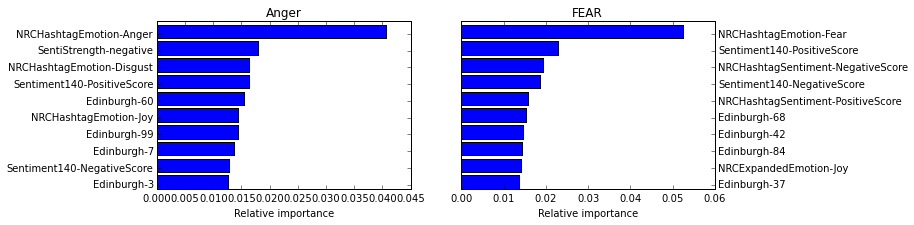

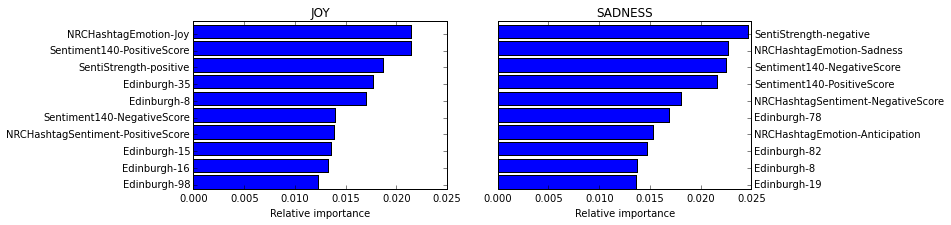

In [4]:
def plot_fig(regr, labels, title, num, subnum):
    f = plt.figure(num, figsize=(10, 3))
    ax = f.add_subplot(subnum)
    if subnum % 2 == 0:
        ax.yaxis.tick_right()
    indices = np.argsort(regr.feature_importances_)[-10:]
    plt.barh(np.arange(len(indices)), regr.feature_importances_[indices])
    plt.yticks(np.arange(len(indices)) + 0.25, np.array(labels)[indices])
    plt.xlabel('Relative importance')
    plt.title(title)
    
plot_fig(anger_regr, anger_features, 'Anger', 1, 121)
plot_fig(fear_regr, fear_features, 'FEAR', 1, 122)
plot_fig(joy_regr, joy_features, 'JOY', 2, 121)
plot_fig(sadness_regr, sadness_features, 'SADNESS', 2, 122)